# Part 1: Classification

In [28]:
# read data into a DataFrame
import pandas as pd
import pylab as plt
import pydotplus
import seaborn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import numpy.random as nprnd
import random
import json
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from IPython.display import Image
from sklearn.externals.six import StringIO
pd.set_option('display.max_columns', 500)
%matplotlib inline

1) Load in the dataset `https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv` into a pandas dataframe

In [29]:
df = pd.read_csv('https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv')
df.head()

,Unnamed: 0,default,student,balance,income
0,1,No,No,729.526495,44361.625074
1,2,No,Yes,817.180407,12106.134700
2,3,No,No,1073.549164,31767.138947
3,4,No,No,529.250605,35704.493935
4,5,No,No,785.655883,38463.495879


2) Convert `default` and `student` to categorical variables.

In [30]:
df.default.replace(to_replace=dict(Yes=1, No=0), inplace=True)
df.student.replace(to_replace=dict(Yes=1, No=0), inplace=True)
df = df.drop('Unnamed: 0', axis=1)
df.head()

,default,student,balance,income
0,0,0,729.526495,44361.625074
1,0,1,817.180407,12106.134700
2,0,0,1073.549164,31767.138947
3,0,0,529.250605,35704.493935
4,0,0,785.655883,38463.495879


3) Make boxplots of all of the variables and a scatter plot of of (balance,income) with the color
of the outcome of `default` labeled red if yes and blue if no. 

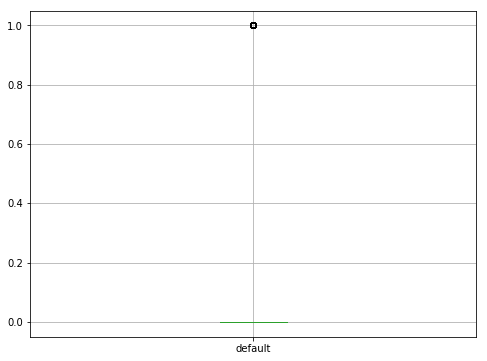

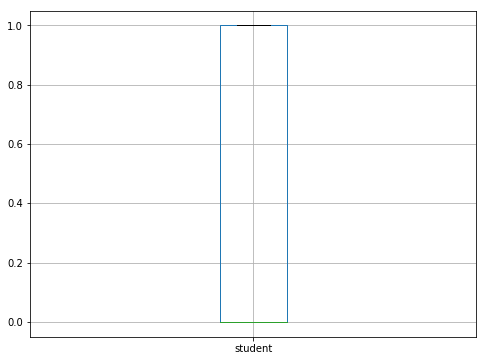

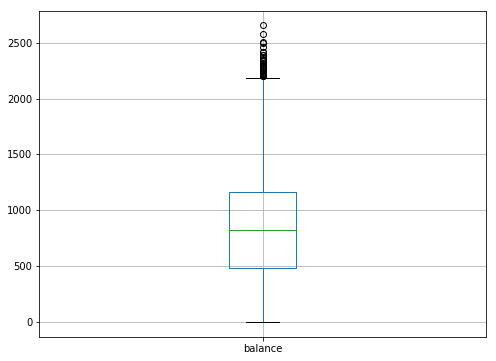

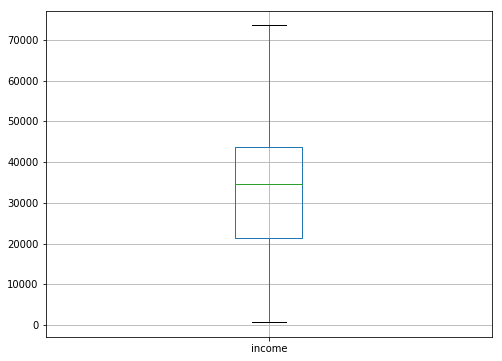

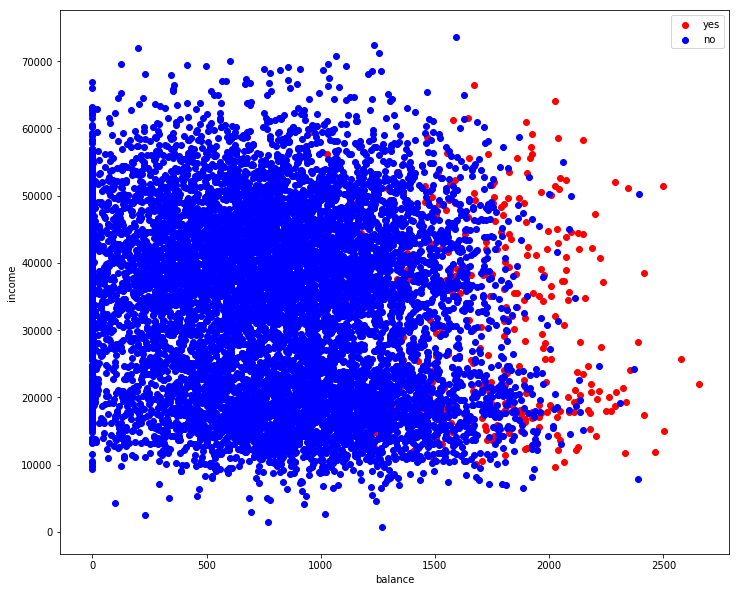

In [31]:
# made separate boxplots because of the large difference in scale between variables
df.boxplot(column = 'default', figsize=(8,6))
plt.show()

df.boxplot(column = 'student', figsize=(8,6))
plt.show()

df.boxplot(column = 'balance', figsize=(8,6))
plt.show()

df.boxplot(column = 'income', figsize=(8,6))
plt.show()

# scatter plot
defaulted_yes = df.loc[df['default'] == 1]
defaulted_no = df.loc[df['default'] == 0]
plt.figure(figsize=(12, 10))
plt.scatter(defaulted_yes['balance'],defaulted_yes['income'],color = 'red', label='yes')
plt.scatter(defaulted_no['balance'],defaulted_no['income'],color = 'blue', label='no')
plt.xlabel('balance')
plt.ylabel('income')
plt.legend()
plt.show()

4) Train a model to predict if a student defaults on their loan or not using LogisticRegression based soley
on the `balance` and `income` variables. Plot the decision boundary in the scatter plot you made in 3) and compute the AUC ROC.

In [32]:
students_only = df.loc[df['student'] == 1]
X = students_only[['balance', 'income']]
y = students_only['default']

# Split the targets into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

regr = LogisticRegression(penalty='l1')

# Train the model using the training sets
regr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

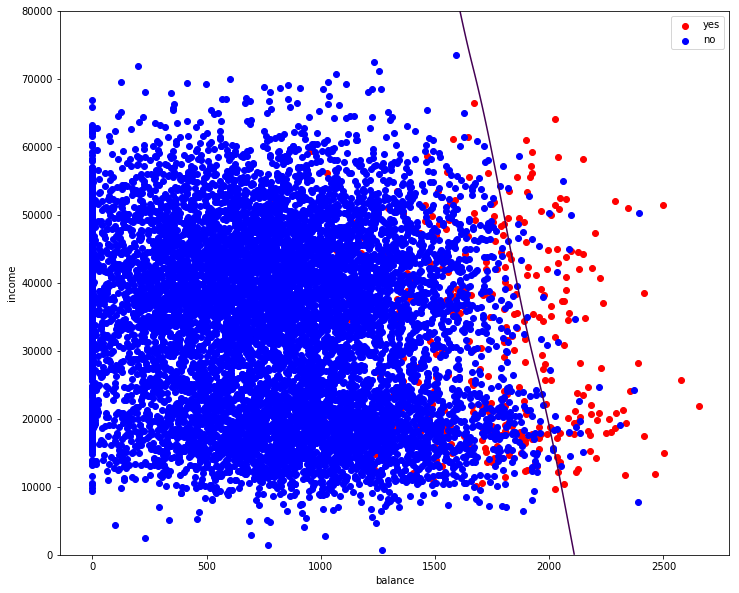

In [33]:
# generate balance range, generate income range
bdy_x = np.linspace(0, 2500, 10)
bdy_y = np.linspace(0, 80000, 100)

# meshgrid explanation https://stackoverflow.com/questions/12864445/numpy-meshgrid-points
balance, income = np.meshgrid(bdy_x, bdy_y)
test_points = pd.DataFrame({'balance':balance.ravel(),'income':income.ravel()})

# make predictions 
probs = regr.predict_proba(test_points)

# plot decision boundary 
# source: https://stackoverflow.com/questions/28256058/plotting-decision-boundary-of-logistic-regression
defaulted_yes = df.loc[df['default'] == 1]
defaulted_no = df.loc[df['default'] == 0]
plt.figure(figsize=(12, 10))
plt.scatter(defaulted_yes['balance'],defaulted_yes['income'],color = 'red', label='yes')
plt.scatter(defaulted_no['balance'],defaulted_no['income'],color = 'blue', label='no')
plt.contour(balance, income, probs[:, 1].reshape(balance.shape), levels=[.5])
plt.xlabel('balance')
plt.ylabel('income')
plt.legend()
plt.show()


Area under the ROC curve : 0.907882


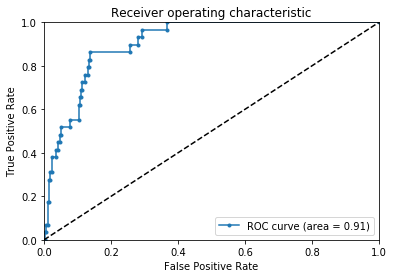

In [35]:
# Computes the AUC ROC of the classifier.
def generate_auc(X,y,clf_class,**kwargs):
    # Construct training and testing set.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
    # Choose SVC classifier.
    classifier = clf_class(**kwargs)
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    print ("Area under the ROC curve : %f" % roc_auc)
    return fpr, tpr, roc_auc, thresholds, classifier

# Generate ROC  for LR with l1 penalty and C=0.1
fpr,tpr,roc_auc, thresholds,regr = generate_auc(X,y,LogisticRegression,penalty='l1')
def generate_ROCplot(fpr,tpr,label,roc_auc):
    plt.clf()
    plt.plot(fpr, tpr, '.-',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)

5) Repeat 4) but with the student variable included. Optimize using Ridge regression and plot the ranking
of coefficients.  How does performance improve with the added variable?

[  1.00000000e-06   1.14975700e-06   1.32194115e-06   1.51991108e-06
   1.74752840e-06   2.00923300e-06   2.31012970e-06   2.65608778e-06
   3.05385551e-06   3.51119173e-06   4.03701726e-06   4.64158883e-06
   5.33669923e-06   6.13590727e-06   7.05480231e-06   8.11130831e-06
   9.32603347e-06   1.07226722e-05   1.23284674e-05   1.41747416e-05
   1.62975083e-05   1.87381742e-05   2.15443469e-05   2.47707636e-05
   2.84803587e-05   3.27454916e-05   3.76493581e-05   4.32876128e-05
   4.97702356e-05   5.72236766e-05   6.57933225e-05   7.56463328e-05
   8.69749003e-05   1.00000000e-04   1.14975700e-04   1.32194115e-04
   1.51991108e-04   1.74752840e-04   2.00923300e-04   2.31012970e-04
   2.65608778e-04   3.05385551e-04   3.51119173e-04   4.03701726e-04
   4.64158883e-04   5.33669923e-04   6.13590727e-04   7.05480231e-04
   8.11130831e-04   9.32603347e-04   1.07226722e-03   1.23284674e-03
   1.41747416e-03   1.62975083e-03   1.87381742e-03   2.15443469e-03
   2.47707636e-03   2.84803587e-03

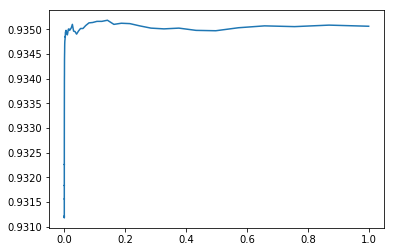

In [37]:
X = df[['student', 'balance', 'income']]
y = df['default']
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the targets into training/testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

C_values = np.logspace(-6, 0, 100)
print(C_values)
auc_roc_vals = []

for c in C_values:
    fpr,tpr,roc_auc, thresholds,regr = generate_auc(X,y,LogisticRegression,penalty='l2',C=c)
    auc_roc_vals.append(roc_auc)
    
best_c=C_values[np.argmax(auc_roc_vals)]
print('optimal c value: ', best_c)
plt.plot(C_values, auc_roc_vals)

Area under the ROC curve : 0.935186


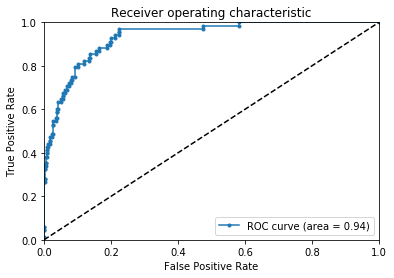

In [38]:
# Generate ROC  for LR with l2 penalty and C=0.1
fpr,tpr,roc_auc, thresholds,regr = generate_auc(X,y,LogisticRegression,penalty='l2', C=best_c)

# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)

When including the student variable and optimizing the hyperparameter in ridge regression, the AUC ROC is 0.9352, compared to 0.9079 in part 4 where we did lasso regression without optimizing the hyperparameter using only balance and income. We can see that including the student variable improves performance of the model. 

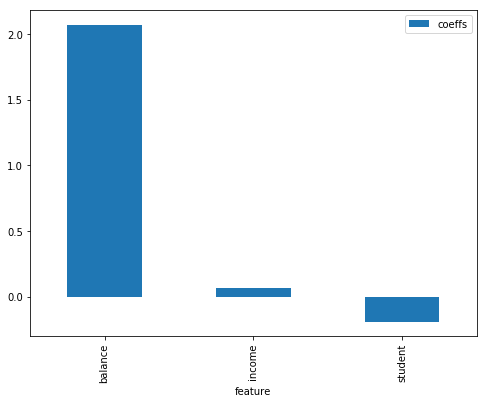

In [39]:
df_coeffs = pd.DataFrame({'coeffs':regr.coef_.flatten(), 'feature':['student', 'balance', 'income']})

# sort in descending order
sorted_coeffs=df_coeffs.sort_values('coeffs', ascending = False)

# plot coefficients
sorted_coeffs.plot(x='feature',y='coeffs',kind='bar', figsize=(8,6))

6) Using cross validation, check that the model you built in 5) is robust (generalizes to other random folds of the dataset).

0.935186030934
0.958717572412
0.955849497546
0.951306595404
0.947486603337


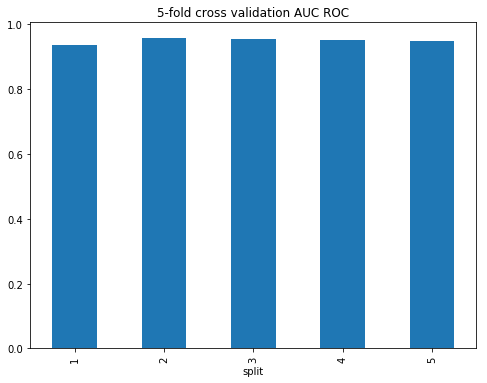

In [40]:
X = df[['student', 'balance', 'income']]
y = df['default']
scaler = StandardScaler()
X = scaler.fit_transform(X)

from sklearn.cross_validation import KFold
folds = 5
kf = KFold(len(y),n_folds=folds,shuffle=True,random_state=10)
auc_roc_vals=[]

# Iterate through folds
for train_index, test_index in kf:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Initialize a classifier with key word arguments
    regr = LogisticRegression(penalty='l2', C=best_c)

    # Train the model using the training sets
    regr.fit(X_train, y_train)
    probs = regr.predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probs[:, 1])
    roc_auc = auc(fpr, tpr)
    print(roc_auc)
    auc_roc_vals.append(roc_auc)
auc_roc_kf = pd.DataFrame({'AUC ROC':auc_roc_vals, 'split':np.asarray(range(1,folds+1))})
auc_roc_kf.plot(x='split',y='AUC ROC',kind='bar', figsize=(8,6), legend=False, title = str(folds) + '-fold cross validation AUC ROC')
    

Performing 5-fold cross validation on our model using $L_2$ regularization with C = 0.141747416293, we can see that we obtain good and consistent performance across various random splits of the dataset, meaning our model is robust.

7) Train a Decision Tree classifier with maximum depth 5 and plot the decision tree. How does performance compare?

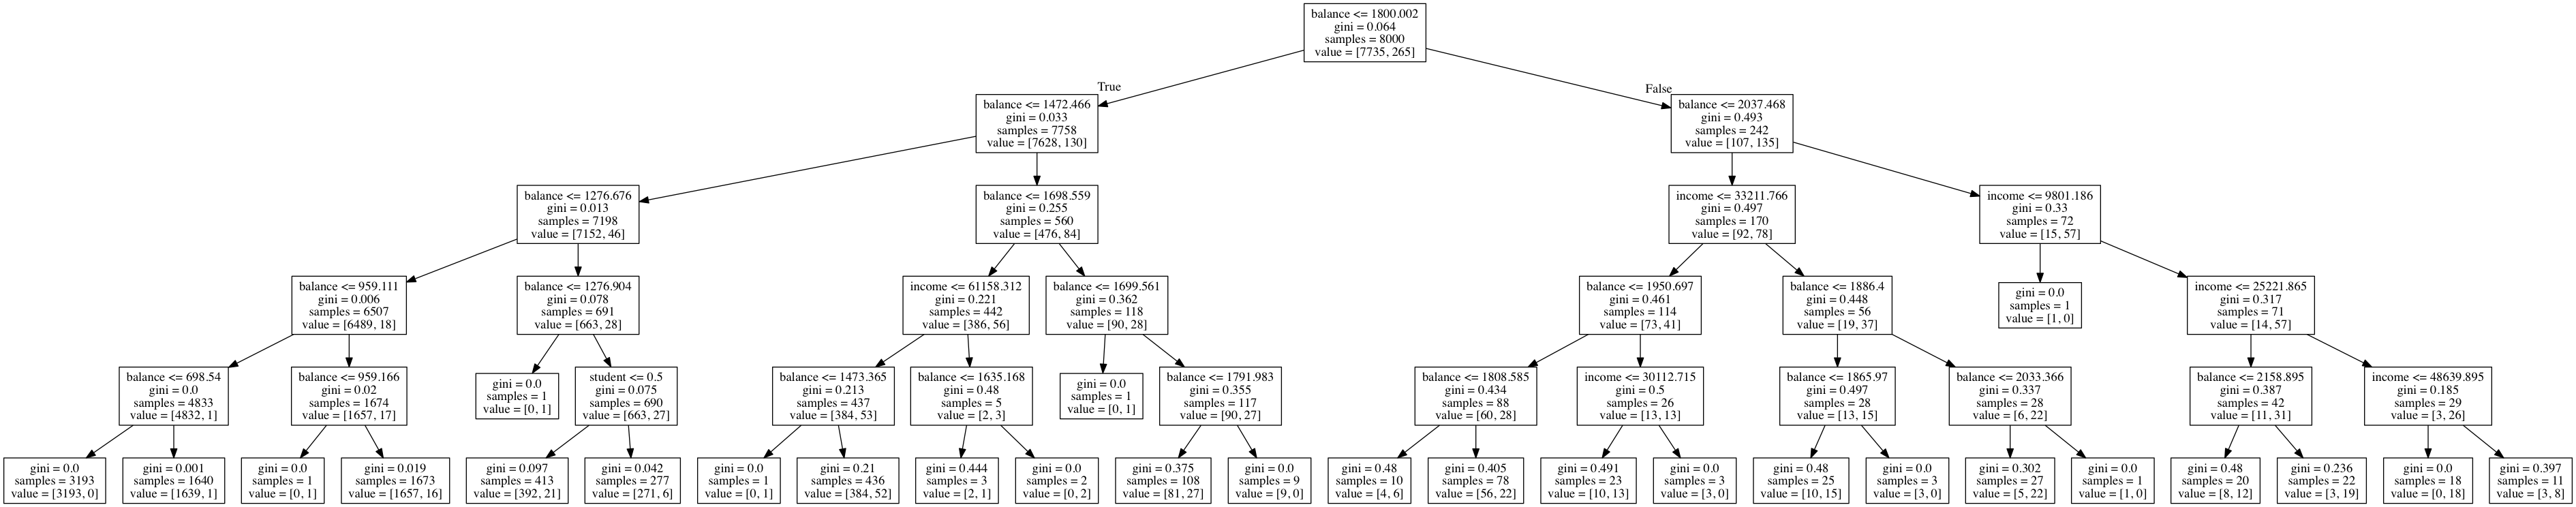

In [43]:
X = df[['student', 'balance', 'income']]
y = df['default']

# Split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Train model
clf = DecisionTreeClassifier(max_depth=5)
clf.fit(X_train,y_train)

# Predict
y_pred = clf.predict(X_test)

dot_data=export_graphviz(clf, out_file=None,feature_names=X_train.columns)
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png()) 

Area under the ROC curve : 0.915384


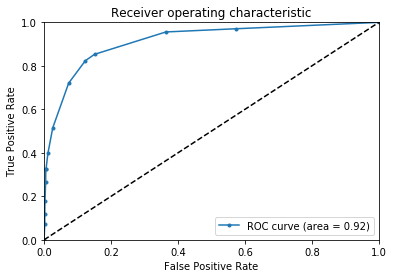

In [44]:
# Train a Decision Tree classifier with maximum depth 5
fpr,tpr,roc_auc,thresholds,clf = generate_auc(X,y,DecisionTreeClassifier,max_depth=5)
generate_ROCplot(fpr,tpr,'LR',roc_auc)

The AUC ROC of the decision tree classifier of depth 5 is 0.9154, compared to the AUC ROC of the classifier we found in part 5, which was 0.9352. Since the decision tree classifier of depth 5 has slightly worse performance, we may not be using the optimal decision tree depth.

8) Find the optimal decision tree depth and compute the AUC ROC. 

Area under the ROC curve : 0.693612
Area under the ROC curve : 0.841995
Area under the ROC curve : 0.894654
Area under the ROC curve : 0.923833
Area under the ROC curve : 0.903890
Area under the ROC curve : 0.904358
optimal decision tree depth: 4 with AUC ROC value: 0.923833120205


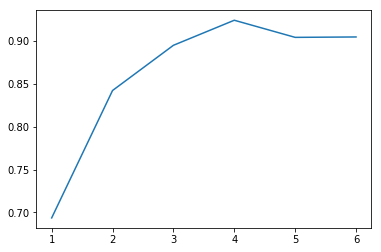

In [45]:
X = df[['student', 'balance', 'income']]
y = df['default']

depths = range(1,7)
auc_roc_vals = []

for depth in depths:
    fpr,tpr,roc_auc, thresholds,clf = generate_auc(X,y,DecisionTreeClassifier,max_depth=depth)
    auc_roc_vals.append(roc_auc)
    
best_depth=depths[np.argmax(auc_roc_vals)]
print('optimal decision tree depth:', best_depth, 'with AUC ROC value:', np.amax(auc_roc_vals))
plt.plot(depths, auc_roc_vals)

Area under the ROC curve : 0.923833


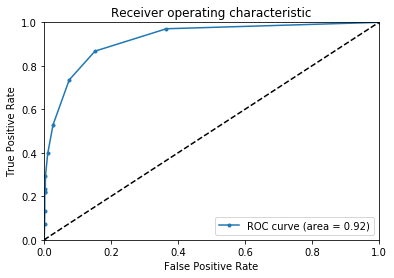

In [48]:
fpr,tpr,roc_auc, thresholds,clf = generate_auc(X,y,DecisionTreeClassifier,max_depth=best_depth)
generate_ROCplot(fpr,tpr,'LR',roc_auc)

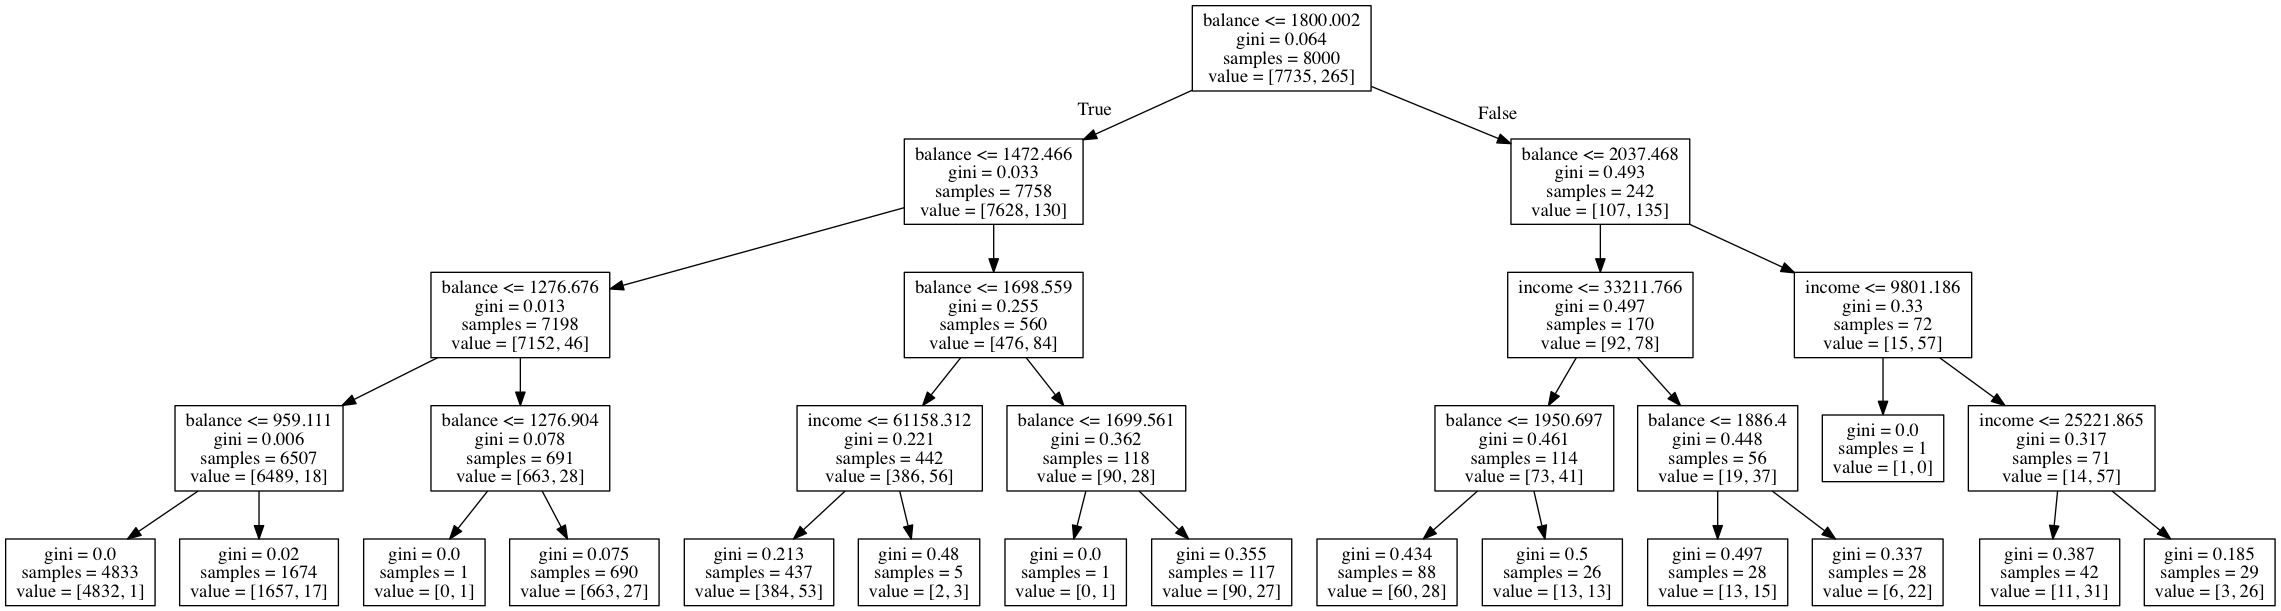

In [47]:
dot_data=export_graphviz(clf, out_file=None,feature_names=X_train.columns)
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png()) 

The optimal decision tree has depth 4 with AUC ROC value 0.9238, which is still slightly lower than the AUC ROC value of 0.9352 for our optimal classifier found using $L2$ regularization on logistic regression.